In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#**Database schema PGVector embedding flow**

Steps followed:

1. Dymamic schema reads for the supplied PG schema.
2. Text embedding using LangChain for vectorising the schema
3. Leveraging PgVector capabilities for persisting the created vector for table and column information seperately


------
**Implementation:** This notebook conatins the LangChain based design for generating and storing the embeddings for the  Postgre SQL database schema details.


  **Design:**
  We have refered to the design mentioned in one of Google Blog and the notebook below
  Blog: https://cloud.google.com/blog/products/databases/faster-similarity-search-performance-with-pgvector-indexes/
  Notebook: https://colab.sandbox.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/cloud-sql/postgres/pgvector/notebooks/pgvector_gen_ai_demo.ipynb#scrollTo=C5SwRvvKJvcz
  

**Architecture diagram**

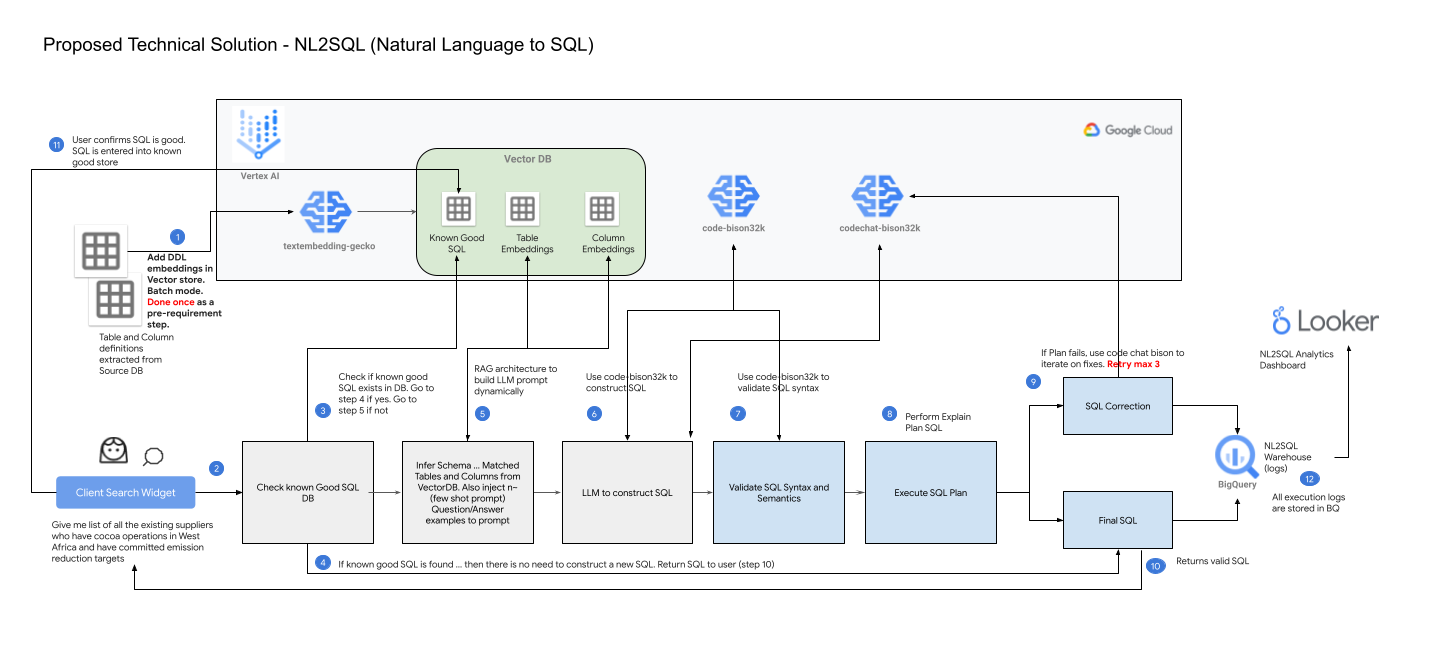

Test Dataset: bigquery-public-data.imdb from BQ


## **Installing all the required dependencies**

[Requires cleanup]

In [ ]:
first = True
if first:
  ! pip install google-cloud-aiplatform --upgrade
  # ! pip install shapely==1.8.5
  ! pip install "cloud-sql-python-connector[pg8000]"
  # Install dependencies.
  !pip install asyncio asyncpg cloud-sql-python-connector["asyncpg"]
  !pip install numpy --upgrade
  !pip install pandas
  !pip install pgvector
  !pip install langchain transformers

  Using cached pg8000-1.30.4-py3-none-any.whl (54 kB)
  Using cached scramp-1.4.4-py3-none-any.whl (13 kB)
  Using cached asn1crypto-1.5.1-py2.py3-none-any.whl (105 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.7/806.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# @markdown Replace the required placeholder text below. You can modify any other default values, if you like.

# Please fill in these values.
project_id = "steveswalker-sandbox"  # @param {type:"string"}
database_password = "text2sql-demo-pg"  # @param {type:"string"}
region = "us-central1"  # @param {type:"string"}
instance_name = "text2sql-demo-pg"  # @param {type:"string"}
database_name = "nl2sql_test"  # @param {type:"string"}
database_user = "postgres"  # @param {type:"string"}
pg_schema = "retail"  # @param {type:"string"}
embeddings_model = "textembedding-gecko@001"  # @param {type:"string"}


# Quick input validations.
assert project_id, "⚠️ Please provide a Google Cloud project ID"
assert region, "⚠️ Please provide a Google Cloud region"
assert instance_name, "⚠️ Please provide the name of your instance"
assert database_name, "⚠️ Please provide a database name"
assert database_user, "⚠️ Please provide a database user"
assert database_password, "⚠️ Please provide a database password"
assert pg_schema, "⚠️ Please provide a schema name"

##Authenticate your Google Cloud Account and enable APIs.

In [ ]:
#@markdown

# Authenticate gcloud.
from google.colab import auth
auth.authenticate_user()

# Configure gcloud.
!gcloud config set project {project_id}

# Grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

!gcloud projects add-iam-policy-binding {project_id} \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"


# Enable Cloud SQL Admin API
!gcloud services enable sqladmin.googleapis.com
!gcloud services enable aiplatform.googleapis.com

Updated property [core/project].
Updated IAM policy for project [steveswalker-sandbox].
bindings:
- members:
  - serviceAccount:411826505131-compute@developer.gserviceaccount.com
  - serviceAccount:732814971409-compute@developer.gserviceaccount.com
  - serviceAccount:ext-vertexai-image-catalo-ili1@genai-solution-assets.iam.gserviceaccount.com
  - serviceAccount:svc-gen-ai-steveswalker-sandbo@steveswalker-sandbox.iam.gserviceaccount.com
  - user:rkgmd1729@gmail.com
  role: roles/aiplatform.admin
- members:
  - serviceAccount:service-542763728582@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-542763728582@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-542763728582@gcp-sa-aiplatform.iam.gserviceaccount.com
  - serviceAccount:text2sql@steveswalker-sandbox.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:

## **Importing all the required libraries** [Needs further clean-up]

In [ ]:
import datetime
import urllib
import json
import re
import time
import textwrap
import pandas as pd
import os
from google.cloud import storage
import io
import pandas as pd
from google.cloud import storage
from io import StringIO
from sqlalchemy import create_engine
from sqlalchemy.engine import Engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from google.cloud.sql.connector import Connector, IPTypes
from sqlalchemy.sql import text
from google.colab import data_table
from vertexai.language_models import TextEmbeddingModel
data_table.enable_dataframe_formatter()

agent = None

In [ ]:
from google.colab import auth
auth.authenticate_user()

##Schema Embedding

### PostGre Util functions

Helper function used for synchronus interaction with PG

In [ ]:
def cloudSQL_pg_create_df(query: str, schema: str = 'userbase', group_concat_max_len: int = 102400):


    # initialize Connector object
    connector = Connector()

    # function to return the database connection object
    def getconn():
        conn = connector.connect(
            "steveswalker-sandbox:us-central1:text2sql-demo-pg",
            "pg8000",
            user="postgres",
            password="text2sql-demo-pg",
            db="nl2sql_test"
        )
        return conn

    # create connection pool with 'creator' argument to our connection object function
    pool = create_engine(
        "postgresql+pg8000://",
        creator=getconn,
    )

    result_df=pd.DataFrame()
    # connect to connection pool
    with pool.connect() as db_conn:
        # query and fetch ratings table
          df = pd.read_sql(text(query), con=db_conn)
          # con.close()
          result_df = df

    return result_df




In [ ]:
def text_embedding(question):
    """Text embedding with a Large Language Model."""
    model = TextEmbeddingModel.from_pretrained(embeddings_model)
    embeddings = model.get_embeddings([question])
    for embedding in embeddings:
        vector = embedding.values
        print(f"Length of Embedding Vector: {len(vector)}")
    return vector

In [ ]:
table_schema_sql = '''
SELECT table_schema, table_name,table_description, array_to_string(array_agg(column_name), ' , ') as table_column
FROM
(select c.table_schema,c.table_name,c.column_name,c.ordinal_position,c.column_default,c.data_type,d.description, obj_description(c1.oid) as table_description
from information_schema.columns c
inner join pg_class c1
on c.table_name=c1.relname
inner join pg_catalog.pg_namespace n
on c.table_schema=n.nspname
and c1.relnamespace=n.oid
left join pg_catalog.pg_description d
on d.objsubid=c.ordinal_position
and d.objoid=c1.oid
where
c.table_schema='{pg_schema}') data
GROUP BY table_schema, table_name, table_description
ORDER BY table_name;
'''.format(pg_schema=pg_schema)

column_schema_sql = '''
WITH
  columns_schema
  AS
  (select c.table_schema,c.table_name,c.column_name,c.data_type,d.description as column_description, obj_description(c1.oid) as table_description
from information_schema.columns c
inner join pg_class c1
on c.table_name=c1.relname
inner join pg_catalog.pg_namespace n
on c.table_schema=n.nspname
and c1.relnamespace=n.oid
left join pg_catalog.pg_description d
on d.objsubid=c.ordinal_position
and d.objoid=c1.oid
where
c.table_schema='{pg_schema}'),
pk_schema as
(SELECT table_name, column_name AS primary_key
FROM information_schema.key_column_usage
WHERE TABLE_SCHEMA='{pg_schema}'
AND CONSTRAINT_NAME like '%_pkey%'
ORDER BY table_name, primary_key),
fk_schema as
(SELECT table_name, column_name AS foreign_key
  FROM information_schema.key_column_usage
  WHERE TABLE_SCHEMA='{pg_schema}'
  AND CONSTRAINT_NAME like '%_fkey%'
  ORDER BY table_name, foreign_key)

select lr.*,
case
when primary_key is not null then 'Primary key for this table'
when foreign_key is not null then CONCAT('Foreign key',column_description)
else null
END as column_constraints
from
(select l.*,r.primary_key
from
columns_schema l
left outer join
pk_schema r
on
l.table_name=r.table_name
and
l.column_name=r.primary_key) lr
left outer join
fk_schema rt
on
lr.table_name=rt.table_name
and
lr.column_name=rt.foreign_key
;
'''.format(pg_schema=pg_schema)


pk_sql = '''
SELECT table_name, column_name AS primary_key
FROM information_schema.key_column_usage
WHERE TABLE_SCHEMA='{pg_schema}'
AND CONSTRAINT_NAME like '%_pkey%'
ORDER BY table_name, primary_key;
'''.format(pg_schema=pg_schema)

fk_sql = '''
SELECT table_name, column_name AS foreign_key
  FROM information_schema.key_column_usage
  WHERE TABLE_SCHEMA='{pg_schema}'
  AND CONSTRAINT_NAME like '%_fkey%'
  ORDER BY table_name, foreign_key;
'''.format(pg_schema=pg_schema)


sample_query_sql=f"select * from query_example_embeddings where database_name='{pg_schema}'".format(pg_schema=pg_schema)

In [ ]:
table_desc_df = cloudSQL_pg_create_df(table_schema_sql)
column_name_df = cloudSQL_pg_create_df(column_schema_sql)
sql_example_df = cloudSQL_pg_create_df(sample_query_sql)

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after
/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after
/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


In [ ]:
# column_name_df.head()

### Augment all the DB schema blocks to create document for embedding

In [ ]:
# Augment columns dataframe with detailed description. This detailed description column will be the one used as the document when adding the record to the VectorDB

aug_table_df = table_desc_df

print(len(aug_table_df))
print(len(table_desc_df))

cur_table_name = ""
cur_table_owner = ""
cur_full_table= cur_table_owner + '.' + cur_table_name
table_col_comments=[]


for index_aug, row_aug in aug_table_df.iterrows():

  cur_table_name = str(row_aug['table_name'])
  cur_table_schema = str(row_aug['table_schema'])
  cur_full_table= cur_table_owner + '.' + cur_table_name
  curr_col_name = str(row_aug['table_column'])
  curr_tbl_desc = str(row_aug['table_description'])

  # print('\n' + cur_table_owner + '.' + cur_table_name + ':')

  col_comments_text=f"""Schema Name: {cur_table_schema} | Table Name: {cur_table_name} (Table Description - {curr_tbl_desc}) | Columns List: [{curr_col_name}]"""

  table_col_comments.append(col_comments_text)
  # print(' Column ' + cur_full_table + '.' + curr_col_name + " Description: " + col_comments_text)
  aug_table_df.at[index_aug, 'detailed_description'] = col_comments_text


3
3


In [ ]:
# Augment columns dataframe with detailed description. This detailed description column will be the one used as the document when adding the record to the VectorDB

aug_columns_df = column_name_df

print(len(aug_columns_df))
print(len(column_name_df))

cur_table_name = ""
cur_table_owner = ""
cur_full_table= cur_table_owner + '.' + cur_table_name
table_col_comments=[]


for index_aug, row_aug in aug_columns_df.iterrows():

  cur_table_name = str(row_aug['table_name'])
  cur_table_owner = str(row_aug['table_schema'])
  curr_table_description = str(row_aug['table_description'])
  cur_full_table= cur_table_owner + '.' + cur_table_name
  curr_col_name = str(row_aug['table_schema'])+'.'+str(row_aug['table_name'])+'.'+str(row_aug['column_name'])
  curr_col_datatype = str(row_aug['data_type'])
  curr_col_description = str(row_aug['column_description'])
  curr_col_constraints = str(row_aug['column_constraints'])

  # print('\n' + cur_table_owner + '.' + cur_table_name + ':')

  col_comments_text=f"""Schema Name:{cur_table_owner} | Table Name: {cur_table_name} (Table description: {curr_col_description}) | Column details: {curr_col_name} (Data type: {curr_col_datatype})(column description: {curr_col_description})(constraints: {curr_col_constraints})"""

  table_col_comments.append(col_comments_text)
  # print(' Column ' + cur_full_table + '.' + curr_col_name + " Description: " + col_comments_text)
  aug_columns_df.at[index_aug, 'detailed_description'] = col_comments_text


27
27


In [ ]:
aug_columns_df

,table_schema,table_name,column_name,data_type,column_description,table_description,primary_key,column_constraints,detailed_description
0,retail,products,cluster_id,character varying,None,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...
1,retail,products,hierarchy1_id,character varying,None,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...
2,retail,products,hierarchy2_id,character varying,None,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...
3,retail,products,hierarchy3_id,character varying,None,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...
4,retail,products,hierarchy4_id,character varying,None,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...
5,retail,products,hierarchy5_id,character varying,None,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...
6,retail,products,id_product,character varying,The unique identifier of a product.,Contains the complete information on the produ...,id_product,Primary key for this table,Schema Name:retail | Table Name: products (Tab...
7,retail,products,product_depth,numeric,Depth of product,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...
8,retail,products,product_length,numeric,Length of product,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...
9,retail,products,product_width,numeric,Width of product,Contains the complete information on the produ...,None,None,Schema Name:retail | Table Name: products (Tab...


### Vectorise the table and column details

In [ ]:
# Split long text descriptions into smaller chunks that can fit into
# the API request size limit, as expected by the LLM providers.

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[".", "\n",","],
    chunk_size=500,
    chunk_overlap=0,
    length_function=len,
)


In [ ]:
table_details_chunked = []
for index, row in aug_table_df.iterrows():
    table_schema = row["table_schema"]
    table_name = row["table_name"]
    detailed_description = row["detailed_description"]
    r = {"table_schema": table_schema,"table_name": table_name,"content": detailed_description}
    table_details_chunked.append(r)

tablecolumn_details_chunked = []
for index, row in aug_columns_df.iterrows():
    table_schema = row["table_schema"]
    table_name = row["table_name"]
    column_name = row["column_name"]
    detailed_description = row["detailed_description"]
    r = {"table_schema": table_schema,"table_name": table_name,"column_name":column_name, "content": detailed_description}
    tablecolumn_details_chunked.append(r)

In [ ]:
# Generate the vector embeddings for each chunk of text.
# This code snippet may run for a few minutes.

from langchain.embeddings import VertexAIEmbeddings
from google.cloud import aiplatform
import time

aiplatform.init(project=f"{project_id}", location=f"{region}")
embeddings_service = VertexAIEmbeddings()


# Helper function to retry failed API requests with exponential backoff.
def retry_with_backoff(func, *args, retry_delay=5, backoff_factor=2, **kwargs):
    max_attempts = 10
    retries = 0
    for i in range(max_attempts):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"error: {e}")
            retries += 1
            wait = retry_delay * (backoff_factor**retries)
            print(f"Retry after waiting for {wait} seconds...")
            time.sleep(wait)


batch_size = 10
for i in range(0, len(table_details_chunked), batch_size):
    request = [x["content"] for x in table_details_chunked[i : i + batch_size]]
    response = retry_with_backoff(embeddings_service.embed_documents, request)
    # Store the retrieved vector embeddings for each chunk back.
    for x, e in zip(table_details_chunked[i : i + batch_size], response):
        x["embedding"] = e

# Store the generated embeddings in a pandas dataframe.
table_details_embeddings = pd.DataFrame(table_details_chunked)
# table_details_embeddings.head()

# batch_size = 10
for i in range(0, len(tablecolumn_details_chunked), 1):
    request = [x["content"] for x in tablecolumn_details_chunked[i : i + batch_size]]
    response = retry_with_backoff(embeddings_service.embed_documents, request)
    # Store the retrieved vector embeddings for each chunk back.
    for x, e in zip(tablecolumn_details_chunked[i : i + batch_size], response):
        x["embedding"] = e

# Store the generated embeddings in a pandas dataframe.
tablecolumn_details_embeddings = pd.DataFrame(tablecolumn_details_chunked)
# tablecolumn_details_embeddings.head()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.embeddings.vertexai.VertexAIEmbeddings` was deprecated in langchain-community 0.0.12 and will be removed in 0.2.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import VertexAIEmbeddings`.
  warn_deprecated(


### Store the vectorised table and column details in the PG table

In [ ]:
# Store the generated vector embeddings in a PostgreSQL table.
# This code may run for a few minutes.

import asyncio
import asyncpg
from google.cloud.sql.connector import Connector
import numpy as np
from pgvector.asyncpg import register_vector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("CREATE EXTENSION IF NOT EXISTS vector")
        await register_vector(conn)

        # await conn.execute("DROP TABLE IF EXISTS table_details_embeddings")
        # Create the `table_details_embeddings` table to store vector embeddings.
        await conn.execute(
            """CREATE TABLE IF NOT EXISTS table_details_embeddings(
                                table_schema VARCHAR(1024) NOT NULL,
                                table_name VARCHAR(1024) NOT NULL,
                                content TEXT,
                                embedding vector(768))"""
        )

        # Store all the generated embeddings back into the database.
        for index, row in table_details_embeddings.iterrows():
            await conn.execute(
                """
                DELETE FROM table_details_embeddings
                WHERE
                table_schema = '{row["table_schema"]}'
                and
                table_name = '{row["table_name"]}';
                """
            )
            await conn.execute(
                "INSERT INTO table_details_embeddings (table_schema, table_name, content, embedding) VALUES ($1, $2, $3, $4)",
                row["table_schema"],
                row["table_name"],
                row["content"],
                np.array(row["embedding"]),
            )

        # await conn.execute("DROP TABLE IF EXISTS tablecolumn_details_embeddings")
        # Create the `table_details_embeddings` table to store vector embeddings.
        await conn.execute(
            """CREATE TABLE IF NOT EXISTS tablecolumn_details_embeddings(
                                table_schema VARCHAR(1024) NOT NULL,
                                table_name VARCHAR(1024) NOT NULL,
                                column_name VARCHAR(1024) NOT NULL,
                                content TEXT,
                                embedding vector(768))"""
        )

        # Store all the generated embeddings back into the database.
        for index, row in tablecolumn_details_embeddings.iterrows():
            await conn.execute(
                """
                DELETE FROM tablecolumn_details_embeddings
                WHERE table_schema = '{row["table_schema"]}'
                and
                table_name = '{row["table_name"]}';
                """
            )
            await conn.execute(
                "INSERT INTO tablecolumn_details_embeddings (table_schema, table_name, column_name, content, embedding) VALUES ($1, $2, $3, $4, $5)",
                row["table_schema"],
                row["table_name"],
                row["column_name"],
                row["content"],
                np.array(row["embedding"]),
            )


        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


## Example Query embedding

Below section will embed the example SQLs with its NL-question

In [ ]:
async def getSchema(user_question):

    qe = text_embedding(user_question)
    matches = []
    matches_tbl = []

    async def main():
        loop = asyncio.get_running_loop()
        async with Connector(loop=loop) as connector:
            # Create connection to Cloud SQL database.
            conn: asyncpg.Connection = await connector.connect_async(
                f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
                "asyncpg",
                user=f"{database_user}",
                password=f"{database_password}",
                db=f"{database_name}",
            )

            await register_vector(conn)
            similarity_threshold = 0.1
            num_matches = 100

            table_results = await conn.fetch(
                """
                                WITH vector_matches AS (
                                  SELECT table_name, table_schema, content,
                                  (embedding <=> $1) AS similarity
                                  FROM table_details_embeddings
                                  WHERE 1 - (embedding <=> $1) > $2
                                  LIMIT $3
                                )
                                SELECT string_agg(content,' | ') as schema_dt
                                FROM vector_matches
                                group by table_name, table_schema
                                """,
                qe,
                similarity_threshold,
                num_matches
            )
            if len(table_results) == 0:
              print("Did not find any results. Adjust the query parameters.")
            # else:
            #   print(results)

            table_name_txt = 'Schema(values):'
            for r in table_results:
                # Collect the description for all the matched table schema and will frame the schema
                # print(r["table_schema"])
                table_name_txt=table_name_txt+r["schema_dt"]+" | "
            matches_tbl.append(table_name_txt)

            # Find similar columns details to the query using cosine similarity search
            # over all vector embeddings. This new feature is provided by `pgvector`.
            column_results = await conn.fetch(
                """
                                WITH vector_matches AS (
                                  SELECT table_name, table_schema, content,
                                  (embedding <=> $1) AS similarity
                                  FROM tablecolumn_details_embeddings
                                  WHERE 1 - (embedding <=> $1) > $2
                                  LIMIT $3
                                )
                                SELECT string_agg(content,' | ') as table_schema_det
                                FROM vector_matches
                                group by table_name, table_schema
                                """,
                qe,
                similarity_threshold,
                num_matches
            )

            if len(column_results) == 0:
              print("Did not find any results. Adjust the query parameters.")
            # else:
            #   print(results)

            table_column_txt = 'Column name(type):'
            for r in column_results:
                # Collect the description for all the matched table schema and will frame the schema
                # print(r["table_schema"])
                table_column_txt=table_column_txt+r["table_schema_det"]+" | "
            matches.append(table_column_txt)

            # Close the connection to the database.
            await conn.close()


    await main()  # type: ignore

    tables_schema=matches_tbl[0]
    # Show the results for similar products that matched the user query.
    tables_detailed_schema=matches[0]
    return tables_schema,tables_detailed_schema

In [ ]:
aug_sql_example_df = sql_example_df

print(len(aug_sql_example_df))
print(len(sql_example_df))

cur_table_name = ""
cur_table_owner = ""
cur_full_table= cur_table_owner + '.' + cur_table_name
table_col_comments=[]


for index_aug, row_aug in aug_sql_example_df.iterrows():

  example_user_question = str(row_aug['prompt'])
  example_generated_sql = str(row_aug['sql'])
  tables_schema,tables_detailed_schema = await getSchema(example_user_question)


  sql_example_comments_text=f"""example_user_question: {example_user_question}"""
  #  | example_generated_sql: {example_generated_sql}"""

  table_col_comments.append(col_comments_text)
  # print(' Column ' + cur_full_table + '.' + curr_col_name + " Description: " + col_comments_text)
  aug_sql_example_df.at[index_aug, 'detailed_description'] = sql_example_comments_text


6
6
Length of Embedding Vector: 768
Length of Embedding Vector: 768


/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


Length of Embedding Vector: 768
Length of Embedding Vector: 768
Length of Embedding Vector: 768
Length of Embedding Vector: 768


In [ ]:
example_sql_details_chunked = []
for index, row in aug_sql_example_df.iterrows():
    example_user_question = row["prompt"]
    example_generated_sql = row["sql"]
    detailed_description = row["detailed_description"]
    r = {"example_user_question": example_user_question,"example_generated_sql": example_generated_sql,"content": detailed_description}
    example_sql_details_chunked.append(r)

In [ ]:
for chunk in example_sql_details_chunked:
      request = chunk["content"]
      response = text_embedding(request)
      print("request: "+ request)
      chunk["embedding"] = response

# Store the generated embeddings in a pandas dataframe.
example_prompt_sql_embeddings = pd.DataFrame(example_sql_details_chunked)

Length of Embedding Vector: 768
request: example_user_question: Which city had maximum number of sales?
Length of Embedding Vector: 768
request: example_user_question: Which unique products share same parent hierarchy?
Length of Embedding Vector: 768
request: example_user_question: Which product (with product details) was sold with the maximum discount?
Length of Embedding Vector: 768
request: example_user_question: Which city has maximum number of sales?
Length of Embedding Vector: 768
request: example_user_question: Which product was sold most number of times?
Length of Embedding Vector: 768
request: example_user_question: Which city has maximum number of stores?


In [ ]:
async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("CREATE EXTENSION IF NOT EXISTS vector")
        await register_vector(conn)

        # await conn.execute("DROP TABLE IF EXISTS example_prompt_sql_embeddings")
        await conn.execute(
            """CREATE TABLE IF NOT EXISTS example_prompt_sql_embeddings(
                                table_schema VARCHAR(1024) NOT NULL,
                                example_user_question text NOT NULL,
                                example_generated_sql text NOT NULL,
                                content TEXT,
                                embedding vector(768))"""
        )

        await conn.execute(
                f"""delete from example_prompt_sql_embeddings where table_schema = '{pg_schema}'""")

        # Store all the generated embeddings back into the database.
        for index, row in example_prompt_sql_embeddings.iterrows():
            await conn.execute(
                    "DELETE FROM example_prompt_sql_embeddings WHERE table_schema= $1 and example_user_question=$2",
                  pg_schema,
                  row["example_user_question"])
            await conn.execute(
                "INSERT INTO example_prompt_sql_embeddings (table_schema, example_user_question, example_generated_sql, content, embedding) VALUES ($1, $2, $3, $4, $5)",
                pg_schema,
                row["example_user_question"],
                row["example_generated_sql"],
                row["content"],
                np.array(row["embedding"]),
            )

        await conn.close()


# Run the SQL commands now.
await main()  # type: ignore

/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/refresh_utils.py:214: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after
